In [1]:
# Import External Packages
import scipy.stats as scs
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression

# Importing Custom Functions
import plotFns as psyplt
import helperFns as mf

# Setting Seed for Reproducibility
np.random.seed(2021)

curPath = os.path.abspath(os.getcwd())

In [2]:
IDs = ('GS027', 'GS028', 'GS029', 'GS030', 'GS037', 'GS040', 'JC025', 'JC028', 'JC029', 'JC039', 'JC044', 'JC047', 'JC048', 'JC052', 'JC059', 'JC061', 'JC062', 'JC067')

tmp = 0
DFt = []

tmpp = 0
DFfit = []

allTests = False
nTest = 5
nTrain = 1

for ID in IDs:

    dataBase =  os.path.abspath(os.path.join(curPath,"data/Trajectories/all_learning_sessions/"))
    file = mf.find_files('.pkl', ID + '_trainingData', dataBase)[0]
    with open(file, 'rb') as f:
        loaded_dict = pickle.load(f)

    df1t = cf.extractPredictorsFromWeights(loaded_dict, nTrain)

    if tmp == 0:
        DFt = df1t
        tmp = 1
    else:
        DFt = pd.concat([DFt, df1t], axis = 0)

    dataBase =  os.path.abspath(os.path.join(curPath,"data/Trajectories/with_bias_testing"))
    file = mf.find_files('.pkl', ID + '_biasTestingFitData', dataBase)[0]  
    with open(file, 'rb') as f:
        loaded_dict_2 = pickle.load(f)

    tempS = cf.extractFromTestingSession(loaded_dict_2, nTest)

    if tmpp == 0:
        DFfit = tempS
        tmpp = 1
    else:
        DFfit = pd.concat([DFfit, tempS], axis = 0)

DFt = DFt.reset_index(drop = True)
DFfit = DFfit.reset_index(drop = True)

combinedT = pd.concat([DFt, DFfit], axis = 1)

combined = combinedT.drop('mID', axis = 1)

predV = ['bias_var']
testV = ['sigma_s', 'lambda_s', 'gamma_s','mu_s']

pval_s, corr_s = mf.calculate_pvalues_spearman(combined) 

pval_s.loc[testV,predV]


python(43732) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43733) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43734) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43736) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43737) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43738) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43746) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43748) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43751) Malloc

,bias_var
sigma_s,0.07
lambda_s,0.57
gamma_s,0.823
mu_s,0.001


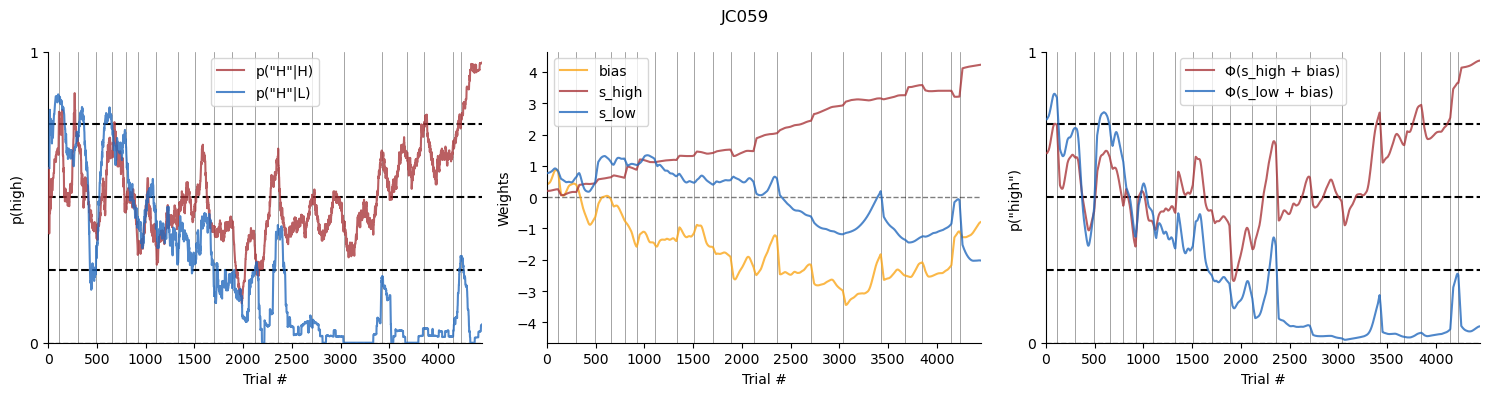

In [3]:
# Figure 2A

dataBase =  os.path.abspath(os.path.join(curPath,"data/Trajectories/with_bias_learning"))

IDs = ('JC059',)
tmp = 0
DFt = []

tmpp = 0
DFfit = []

for ID in IDs:


    plt.rcParams['figure.figsize'] = [15, 4]        
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

    fig, axes = plt.subplot_mosaic(
        [["left",   "middle",  "right"]],
    )           

## Bias

    file = mf.find_files('.pkl', ID + '_trainingDataBias', dataBase)[0]

    with open(file, 'rb') as f:
        loaded_dict = pickle.load(f)

    acc = np.array(loaded_dict['correct'])
    cat = np.array(loaded_dict['answer'])
    emptyMat = np.empty((1,np.size(acc)))
    emptyMat[:] = np.nan
    emptyMat = emptyMat.squeeze()
    acc_low = emptyMat.copy()
    acc_high = emptyMat.copy()
    acc_low[cat == 1] = acc[cat == 1]
    acc_high[cat == 2] = acc[cat == 2]
    acc_low = pd.Series(acc_low).rolling(100,5).apply(lambda x : np.nanmean(x))
    acc_high = pd.Series(acc_high).rolling(100,5).apply(lambda x : np.nanmean(x))

    wModeRaw = np.vstack([acc_high, 1-acc_low])
    weights_raw = {
        'p("H"|H)': 1,
        'p("H"|L)': 1
    }

    fig_weights = psyplt.plot_weights(wModeRaw, weights_raw, ax = axes["left"], days=loaded_dict["dayLength"]) #errorbar=hess_info["W_std"], figsize=(10,6)
    fig_weights.set_ylim(0,1)
    fig_weights.axhline(0.5, color = 'k', linestyle = '--')
    fig_weights.axhline(0.25, color = 'k', linestyle = '--')
    fig_weights.axhline(0.75, color = 'k', linestyle = '--')
    fig_weights.set_ylabel('p(high)')
    fig_weights.legend()


    wMode = loaded_dict['psytrack']['wMode']
    temp =  np.array(list(loaded_dict['psytrack']['weights'].keys()))
    weights = loaded_dict['psytrack']['weights']

    wModeT = wMode.copy()

    for ii, wi in enumerate(wModeT):
        wModeT[ii] = pd.Series(wi).rolling(30,5).apply(lambda x : np.nanmean(x))

    fig_weights = psyplt.plot_weights(wModeT, weights, ax = axes["middle"], days=loaded_dict["dayLength"]) #errorbar=hess_info["W_std"], figsize=(10,6)
    fig_weights.legend()

    if 'bias' in temp:
        weightsT = weights.copy()
        weightsT.pop('bias')
        weightsT['Φ(s_high + bias)'] = weightsT.pop('s_high')
        weightsT['Φ(s_low + bias)'] = weightsT.pop('s_low')

        wModeT = wMode.copy()
        bias = wModeT[temp == 'bias']
        wModeT = wModeT[temp != 'bias']
        wModeT = wModeT + bias
        wModeT = 1/(1+np.exp(-1 * wModeT))
    else:
        weightsT = weights.copy()
        wModeT = wMode.copy()
        wModeT = 1/(1+np.exp(-1 * wModeT)) 

    for ii, wi in enumerate(wModeT):
        wModeT[ii] = pd.Series(wi).rolling(30,5).apply(lambda x : np.nanmean(x))

    fig_weights = psyplt.plot_weights(wModeT, weightsT, ax = axes["right"], days=loaded_dict["dayLength"]) #errorbar=hess_info["W_std"], figsize=(10,6)
    fig_weights.set_ylim(0,1)
    fig_weights.axhline(0.5, color = 'k', linestyle = '--')
    fig_weights.axhline(0.25, color = 'k', linestyle = '--')
    fig_weights.axhline(0.75, color = 'k', linestyle = '--')
    fig_weights.set_ylabel('p("high")')
    fig_weights.legend()

    fig.suptitle(ID)
    fig.tight_layout()

0.67
0.002


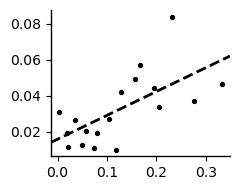

In [4]:
# Figure 2C

titM = ('')

stits = ('Threshold Variability',)

care = ('bias_var',)
label = ('Training Exploration Variability',)

others = ('mu_norm_s',)
ylabs = ('Psychometric Threshold Variability',)

fig, axs = plt.subplots(1,len(care), figsize = (2.5, 2))
axs = np.array(axs)

for ai, ax in enumerate(axs.reshape(-1)):

    y = np.array(combinedT[others[ai]]).reshape(-1, 1)
    x = np.array(combinedT[care[ai]]).reshape(-1, 1)

    reg = LinearRegression().fit(x, y)
    xl = (np.min(x), np.max(x))
    yl = reg.intercept_[0] + reg.coef_[0] * xl

    temp = pd.DataFrame(np.hstack((x,y)))
    p, r = mf.calculate_pvalues_spearman(temp) 
    p = p[0][1]
    r = r[0][1]

    ax.axline((np.mean(x),reg.intercept_[0] + reg.coef_[0][0]*np.mean(x)), slope = reg.coef_[0][0], 
              linewidth = 2, linestyle = '--', color='k', label = 'p = ' + str(p) + ', ' + r'$\rho$' + ' = ' + str(np.round(r,2)))
    ax.scatter(x,y,8,color = 'k')

    print(r)
    print(p)

ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(1)

plt.tight_layout()
plt.show()

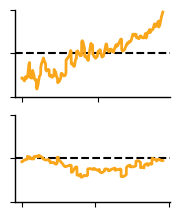

In [5]:
# Figure 2C

dataBase =  os.path.abspath(os.path.join(curPath,"data/Trajectories/all_learning_sessions/"))

img_name = 'variability_bias_traces'
img_loc = 'psytrack'

image_format = 'svg' # e.g .png, .svg, etc.
pathtmp = 'paper_figures/' + img_loc + '/' 

IDst = ['GS028', 'JC048']
colors = ['#FAA61A',"#A9373B","#2369BD"]

fig, ax = plt.subplots(2,1)

for mi, ID in enumerate(IDst):

    file = mf.find_files('.pkl', ID + '_trainingData', dataBase)[0]
    with open(file, 'rb') as f:
        loaded_dict = pickle.load(f)

    bias = loaded_dict['psytrack']['wMode'][0]
    
    ax[mi].axhline(0,linestyle = '--', color = 'k')
    
    ax[mi].plot(bias, linewidth = 2, color = colors[0])

    ax[mi].spines[['right', 'top']].set_visible(False)
    ax[mi].spines[['left', 'bottom']].set_linewidth(1)
    
    ax[mi].set_ylim(-2,2)

    ax[mi].tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        top=False,         # ticks along the top edge are off
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    
    toSave = {
        'trialN': np.array(range(len(bias))),
        'bias': bias
    }

fig.set_size_inches(2,2.5)



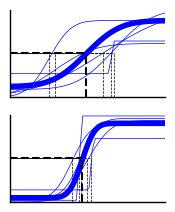

In [6]:
# Figure 2C

vars = np.zeros([5,4])

fig, ax = plt.subplots(2,1)

IDst = ['GS028', 'JC048']

for mi, ID in enumerate(IDst):

    toSave = {}

    dataBase =  os.path.abspath(os.path.join(curPath,"data/Trajectories/with_bias_testing"))
    file = mf.find_files('.pkl', ID + '_biasTestingFitData', dataBase)[0]

    with open(file, 'rb') as f:
        loaded_dict_2 = pickle.load(f)

    fitType = loaded_dict_2['1']['fit_method']

    for si, sID in enumerate(['1','2','3','4','5']):
            
        f = loaded_dict_2[sID]['behavior']['stimulus_frequency']
        r = loaded_dict_2[sID]['behavior']['choice']

        nBins = 15

        binnedMean,binnedFreq, *_ = scs.binned_statistic(f, r, statistic = np.nanmean, bins = nBins, range=(f.min(),f.max()))
        binnedFreq = binnedFreq[:len(binnedFreq)-1] + (binnedFreq[1] - binnedFreq[0])/2

        fn = loaded_dict_2[sID]['function']

        if fitType == 'pymc':
            var = loaded_dict_2[sID]['fit_params']['mean']['mean'][0]
        elif fitType == 'bads':
            var = loaded_dict_2[sID]['fit_params']['mean'].loc[0,:]

        xt = np.linspace(np.log2(6000),np.log2(28000),50)

        vars[si,:] = var

        fit = fn(var, xt)

        ax[mi].plot(xt, fit, color = 'b', linewidth = 0.5, alpha = 1)
        ax[mi].plot([np.min(xt),var[1]],[0.5,0.5],linewidth = 0.5,linestyle = '--',color = 'k')
        ax[mi].plot([var[1],var[1]],[0,0.5],linewidth = 0.5,linestyle = '--',color = 'k')

        toSave[sID] = fit

    varMean = np.mean(vars,0)
    fit = fn(varMean, xt)
    ax[mi].plot(xt, fit, color = 'b', linewidth = 4)
    
    ax[mi].plot([np.min(xt),varMean[1]],[0.5,0.5],linestyle = '--',color = 'k')
    ax[mi].plot([varMean[1],varMean[1]],[0,0.5],linestyle = '--',color = 'k')

    ax[mi].spines[['right', 'top']].set_visible(False)
    ax[mi].spines[['left', 'bottom']].set_linewidth(1)
    ax[mi].set_ylim(0,1)
    ax[mi].set_xlim(xt[0],xt[-1])

    ax[mi].tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off

fig.set_size_inches(2,2.5)

plt.show()


0.437
0.07


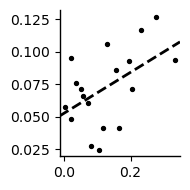

In [7]:
# Figure 2D

titM = ('')
stits = ('Threshold Variability',)

care = ('bias_var',)
label = ('Training Exploration Variability',)
others = ('sigma_s',)
ylabs = ('Psychometric Width Variability',)

fig, axs = plt.subplots(1,len(care), figsize = (2, 2))
axs = np.array(axs)

for ai, ax in enumerate(axs.reshape(-1)):

    y = np.array(combinedT[others[ai]]).reshape(-1, 1)
    x = np.array(combinedT[care[ai]]).reshape(-1, 1)

    reg = LinearRegression().fit(x, y)
    xl = (np.min(x), np.max(x))
    yl = reg.intercept_[0] + reg.coef_[0] * xl

    temp = pd.DataFrame(np.hstack((x,y)))
    p, r = mf.calculate_pvalues_spearman(temp) 
    p = p[0][1]
    r = r[0][1]

    ax.axline((np.mean(x),reg.intercept_[0] + reg.coef_[0][0]*np.mean(x)), slope = reg.coef_[0][0], 
              linewidth = 2, linestyle = '--', color='k', label = 'p = ' + str(p) + ', ' + r'$\rho$' + ' = ' + str(np.round(r,2)))
    ax.scatter(x,y,8,color = 'k')

    print(r)
    print(p)

ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(1)

plt.tight_layout()
plt.show()

0.057
0.823


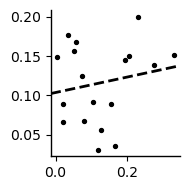

In [8]:
# Figure 2E

titM = ('')

stits = ('Threshold Variability',)

care = ('bias_var',)
label = ('Training Exploration Variability',)

others = ('gamma_s',)
ylabs = ('Psychometric Guess Rate Variability',)

fig, axs = plt.subplots(1,len(care), figsize = (2, 2))
axs = np.array(axs)

for ai, ax in enumerate(axs.reshape(-1)):

    y = np.array(combinedT[others[ai]]).reshape(-1, 1)
    x = np.array(combinedT[care[ai]]).reshape(-1, 1)

    reg = LinearRegression().fit(x, y)
    xl = (np.min(x), np.max(x))
    yl = reg.intercept_[0] + reg.coef_[0] * xl

    temp = pd.DataFrame(np.hstack((x,y)))
    p, r = mf.calculate_pvalues_spearman(temp) 
    p = p[0][1]
    r = r[0][1]

    ax.axline((np.mean(x),reg.intercept_[0] + reg.coef_[0][0]*np.mean(x)), slope = reg.coef_[0][0], 
              linewidth = 2, linestyle = '--', color='k', label = 'p = ' + str(p) + ', ' + r'$\rho$' + ' = ' + str(np.round(r,2)))
    ax.scatter(x,y,8,color = 'k')

    print(r)
    print(p)

ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(1)

plt.tight_layout()
plt.show()


0.143
0.57


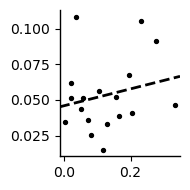

In [9]:
# Figure 2F

titM = ('')

stits = ('Threshold Variability',)# 'Slope')

care = ('bias_var',)
label = ('Training Exploration Variability',)

others = ('lambda_s',)
ylabs = ('Psychometric Lapse Rate Variability',)

fig, axs = plt.subplots(1,len(care), figsize = (2, 2))
axs = np.array(axs)

for ai, ax in enumerate(axs.reshape(-1)):

    y = np.array(combinedT[others[ai]]).reshape(-1, 1)
    x = np.array(combinedT[care[ai]]).reshape(-1, 1)

    reg = LinearRegression().fit(x, y)
    xl = (np.min(x), np.max(x))
    yl = reg.intercept_[0] + reg.coef_[0] * xl

    temp = pd.DataFrame(np.hstack((x,y)))
    p, r = mf.calculate_pvalues_spearman(temp) 
    p = p[0][1]
    r = r[0][1]

    ax.axline((np.mean(x),reg.intercept_[0] + reg.coef_[0][0]*np.mean(x)), slope = reg.coef_[0][0], 
              linewidth = 2, linestyle = '--', color='k', label = 'p = ' + str(p) + ', ' + r'$\rho$' + ' = ' + str(np.round(r,2)))
    ax.scatter(x,y,8,color = 'k')

    print(r)
    print(p)

ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(1)

plt.tight_layout()
plt.show()